In [2]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

# Machine Learning - exploring predictions of mean telomere length post-therapy

## Loading/merging data for ML

In [12]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [13]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                             all_patients_df=all_patients_df)

telo_data.head()

,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,92.916201,99.346299
1,1,2 irrad @ 4 Gy,112.977654,99.346299
2,1,1 non irrad,65.463687,99.346299
3,1,2 irrad @ 4 Gy,104.530726,99.346299
4,1,1 non irrad,61.240223,99.346299


## Train/test split 

In [14]:
telo_test = telo_data.copy()

y = telo_test[['4 C telo means']]
X = telo_test.drop(['4 C telo means'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [15]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [16]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning/modeling data with pipeline

In [11]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## GridSearch for pipeline/model params

In [9]:
# #XGBoost params for grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Cross validation; MAE & R2 score - predicting mean telo telo post-therapy (4 C) using individual telos

In [20]:
fit_xgb_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                          pipe=xgb_pipe, model=model, cv=5)

MAE per CV fold: 
[3.17961985 3.32554761 3.30100655 3.26486214 3.14396837] 

MEAN of MAE all folds: 3.2430009023763824
STD of MAE all folds: 0.06997303726056323

MAE of predict_y_test & y_test: 3.0863018212071216
R2 between predict_y_test & y_test: 0.898797749394823


In [21]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_data, test_set=test_set, 
                                     model=fit_xgb_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 99.34
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 104.82
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 96.48
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.59
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 123.73
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 100.77
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 104.12
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 105.25
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 97.48
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 104.81
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 80.21
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 94.51
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 9

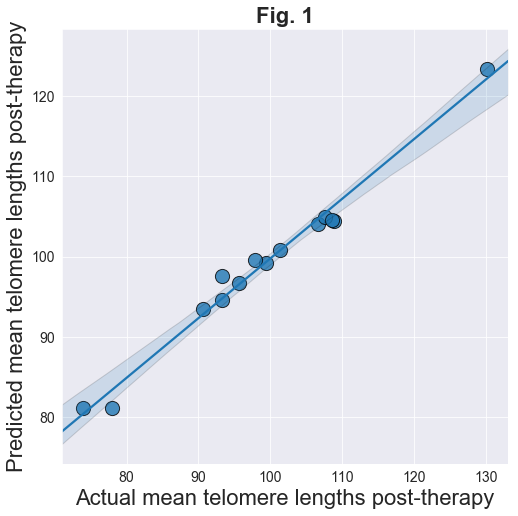

In [32]:
plt.figure(figsize=(8,8))
ax = sns.regplot(x=y_true, y=y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=22)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=22)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 1', fontsize=22, weight='bold')
plt.savefig('predicting mean telos 3 months post.png')

ValueError: Unable to parse node: 0:[individual

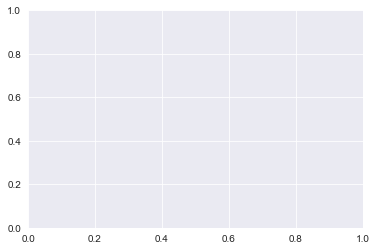

In [37]:
from xgboost import plot_tree

plot_tree(fit_xgb_model)

## Looking directly at actual test 4 C telo means vs. predicted test 4 C telo means

In [22]:
test_clean_process_pipe = clean_process_pipe.set_params(cleaner__drop_patient_id=False)

test_run = test_set.copy()
test_run2 = test_clean_process_pipe.fit_transform(test_run)

In [28]:
test_run2_pred = fit_xgb_model.predict(test_run2[['individual telomeres', 'timepoint_1']])
df_test_run2_pred = pd.DataFrame({'4C telo PREDICTIONS': test_run2_pred})

viz = pd.concat([test_run2, df_test_run2_pred], axis=1)
viz.corr()

,patient id,individual telomeres,4 C telo means,timepoint_1,4C telo PREDICTIONS
patient id,1.000000,-0.232565,-0.508337,-0.006798,-0.493007
individual telomeres,-0.232565,1.000000,0.211477,0.114337,0.269203
4 C telo means,-0.508337,0.211477,1.000000,0.004686,0.956203
timepoint_1,-0.006798,0.114337,0.004686,1.000000,0.003366
4C telo PREDICTIONS,-0.493007,0.269203,0.956203,0.003366,1.000000


In [32]:
viz[viz['patient id'] == 5].groupby('patient id').agg('mean')

,individual telomeres,4 C telo means,timepoint_1,4C telo PREDICTIONS
patient id,,,,
5,99.393172,97.83219,0.492754,99.518654


## Testing if model can predict 4C mean telomere length using *means

In [238]:
all_patients_4C = trp.combine_data(exploded_telos=exploded_telos_all_patients_df,
                                   all_patients_df=all_patients_df,
                                   prediction_objective='4 C means from telo means')

In [228]:
ML_mean_telos_pre = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(all_patients_4C)
ML_mean_telos_clean = ML_mean_telos_pre.copy()

# renaming telos means to enable compatability w/ model
ML_mean_telos_clean.rename(columns={'telo means':'individual telomeres'}, inplace=True)
# dropping to ensure only timepoint/ "individual telomeres" are seen by model
ML_mean_telos_clean.drop(['patient id', '4 C telo means'], axis=1, inplace=True)

In [170]:
pred_4C_telos = model.predict(ML_mean_telos_clean)
pred_4C_telos = pd.DataFrame({'y PREDICT 4C telos': pred_4C_telos})
alpha = pd.concat([ML_mean_telos_pre[['patient id', '4 C telo means']], pred_4C_telos], axis=1)[['patient id', '4 C telo means', 'y PREDICT 4C telos']]
alpha.corr()

,patient id,4 C telo means,y PREDICT 4C telos
patient id,1.000000,-0.508337,-0.339799
4 C telo means,-0.508337,1.000000,0.028171
y PREDICT 4C telos,-0.339799,0.028171,1.000000


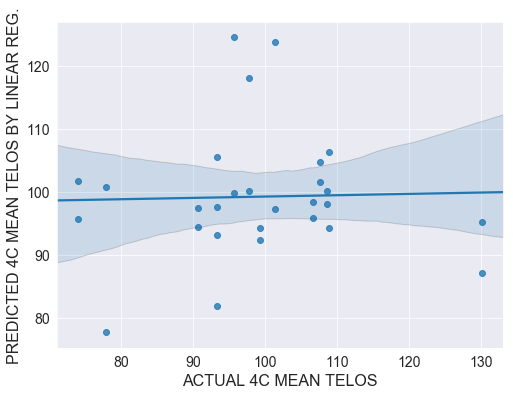

In [171]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=alpha['4 C telo means'], y=alpha['y PREDICT 4C telos'])
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

## Testing if linear regression can predict 4C mean telos using individual telos

In [50]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

fit_lr_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean, 
                                         pipe=lr_pipe, model=lr_model, cv=5)

MAE per CV fold: 
[9.57486504 9.48546811 9.42573546 9.54626994 9.51782078] 

MEAN of MAE all folds: 9.510031865860967
STD of MAE all folds: 0.05154894302086812

MAE of predict_y_test & y_test: 9.521231472663773
R2 between predict_y_test & y_test: 0.04423926648723275


In [51]:
y_lr_predict, y_true = trp.predict_target_4C_compare_actual(telo_data=telo_data_qualify, 
                                                           train_set=train_clean, test_set=test_clean, model=lr_model)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 98.38
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 101.42
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 98.18
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.28
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 98.08
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 99.97
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 100.28
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 99.10
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 101.13
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 100.59
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 98.25
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 97.22
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 97.

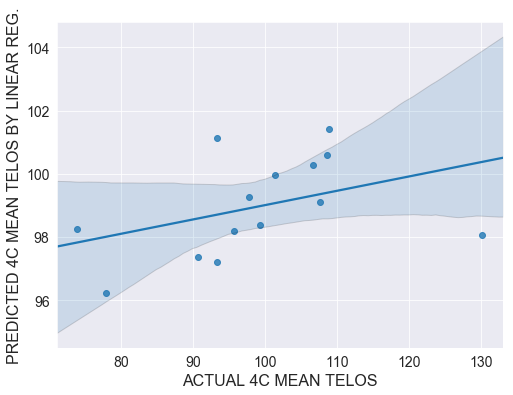

In [52]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=y_lr_predict)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

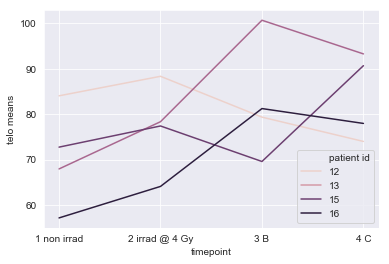

In [396]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[all_patients_df['patient id'].isin([12, 14, 15, 16])])

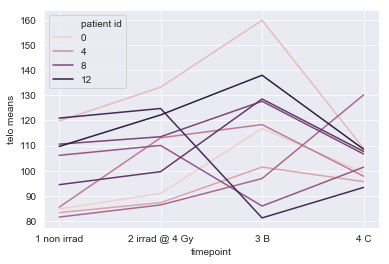

In [393]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[~all_patients_df['patient id'].isin([12, 13, 14, 15, 16])])

In [137]:
training_MAE = []
test_MAE = []
max_depth_XGB = [3, 4, 5, 10, 15, 20, 25]

X = train_clean[['timepoint_1', 'individual telomeres']]
y = train_clean['4 C telo means']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=0)

X_test = test_clean[['timepoint_1', 'individual telomeres']]
y_test = test_clean['4 C telo means']

for param in max_depth_XGB:
    model = XGBRegressor(max_depth=param, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    predict_y_val = model.predict(X_val)
    training_MAE.append(mean_absolute_error(predict_y_val, y_val))
    
    predict_y_test = model.predict(X_test)
    test_MAE.append(mean_absolute_error(predict_y_test, y_test))

In [138]:
viz_traintest_MAE = pd.DataFrame({'training_MAE': training_MAE,
                                  'test_MAE': test_MAE,
                                  'max_depth_XGB': max_depth_XGB})

In [139]:
viz_traintest_MAE = viz_traintest_MAE.melt(id_vars='max_depth_XGB',
                                           value_vars=['training_MAE', 'test_MAE'],
                                           var_name='data type',
                                           value_name='MAE'
                                           )

,max_depth_XGB,data type,MAE
0,3,training_MAE,8.781381
1,4,training_MAE,8.235279
2,5,training_MAE,7.751296
3,10,training_MAE,5.246312
4,15,training_MAE,3.691055


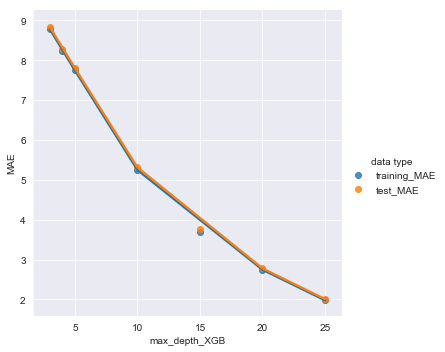

In [140]:
sns.lmplot(x='max_depth_XGB', y='MAE', data=viz_traintest_MAE, hue='data type', lowess=True)

## Visualization

In [80]:
# visualize hyperparameters of XGBoost vs model accuracy
# visualize training vs. test MAE w/ changes params
# visualize fit 

In [526]:
test2 = pd.DataFrame({'predict_y_test': predict_y_test, 'y_test': y_test}).reset_index(drop=True)
test2['residuals'] = test2['predict_y_test'] - test2['y_test']
test2.head()

,predict_y_test,y_test,residuals
0,78.231133,77.956912,0.274221
1,129.140945,130.119423,-0.978477
2,94.292213,93.352615,0.939599
3,129.222321,130.119423,-0.897102
4,94.044617,93.352615,0.692002


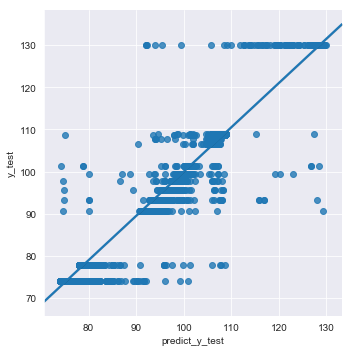

In [527]:
sns.lmplot(x='predict_y_test', y='y_test', data=test2)

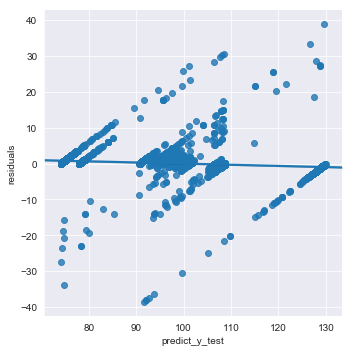

In [504]:
sns.lmplot(x='predict_y_test', y='residuals', data=test2)

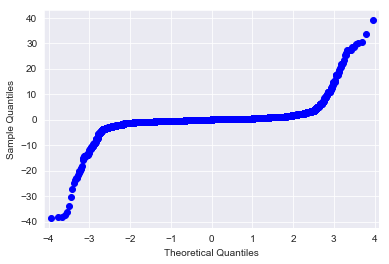

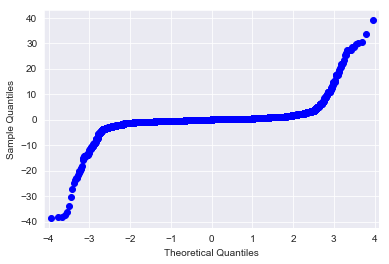

In [505]:
from statsmodels.graphics.gofplots import qqplot
qqplot(test2['residuals'])

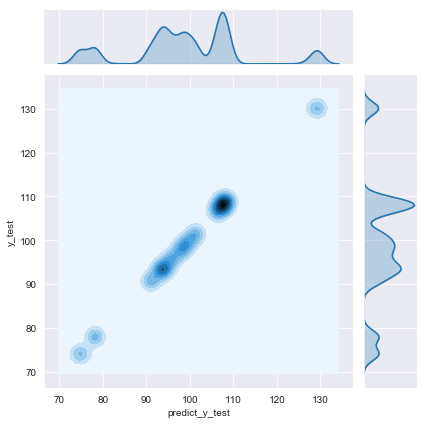

In [506]:
sns.jointplot(x='predict_y_test', y='y_test', kind='kde', data=test2)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [1]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

NameError: name 'pd' is not defined

In [25]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')

quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,92.916201,372.0
1,1,2 irrad @ 4 Gy,112.977654,372.0
2,1,1 non irrad,65.463687,372.0
3,1,2 irrad @ 4 Gy,104.530726,372.0
4,1,1 non irrad,61.240223,372.0


## Train/test split 

In [26]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [27]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [65]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective ='reg:squarederror', random_state=0,)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', clean_process_pipe),
                        ('model', model)
                       ])

## Cleaning/modeling data with pipeline

In [63]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [66]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                            pipe=q_xgb_pipe, model=q_model, cv=5, 
                                            target='4 C # short telos')

MAE per CV fold: 
[193.68307793 197.38824016 192.30764896 186.77620618 188.69615813] 

MEAN of MAE all folds: 191.77026627078558
STD of MAE all folds: 3.7389847889935606

MAE of predict_y_test & y_test: 232.780717375856
R2 between predict_y_test & y_test: 0.8179098385834815


In [67]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe)

patient 1: ACTUAL 4 C # short telos: 372.00 --- PREDICTED 4 C # short telos: 594.61
patient 2: ACTUAL 4 C # short telos: 1182.00 --- PREDICTED 4 C # short telos: 1157.46
patient 3: ACTUAL 4 C # short telos: 503.00 --- PREDICTED 4 C # short telos: 644.38
patient 5: ACTUAL 4 C # short telos: 521.00 --- PREDICTED 4 C # short telos: 698.59
patient 6: ACTUAL 4 C # short telos: 124.00 --- PREDICTED 4 C # short telos: 433.41
patient 7: ACTUAL 4 C # short telos: 1666.00 --- PREDICTED 4 C # short telos: 1461.82
patient 8: ACTUAL 4 C # short telos: 1298.00 --- PREDICTED 4 C # short telos: 1181.30
patient 9: ACTUAL 4 C # short telos: 829.00 --- PREDICTED 4 C # short telos: 886.86
patient 10: ACTUAL 4 C # short telos: 2585.00 --- PREDICTED 4 C # short telos: 1937.16
patient 11: ACTUAL 4 C # short telos: 1258.00 --- PREDICTED 4 C # short telos: 1186.38
patient 12: ACTUAL 4 C # short telos: 2028.00 --- PREDICTED 4 C # short telos: 1631.74
patient 14: ACTUAL 4 C # short telos: 222.00 --- PREDICTED 4 

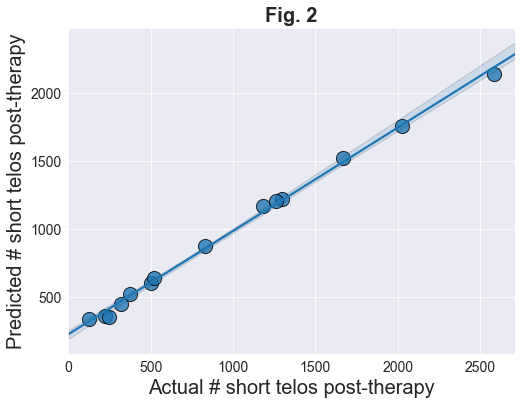

In [41]:
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
# ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
# ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
# ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')

plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')